# Cube dataset evaluation

## Number of epochs
I will try to find on how many epochs should I train the network.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from som import KohonenNetwork, GaussianNeighboringFunc
import pickle

In [2]:
data_dir = Path("data")

cube = pd.read_csv(data_dir / "cube.csv")
hexagon = pd.read_csv(data_dir / "hexagon.csv")

Text(0.5, 0.92, 'Original clusters in the cube dataset')

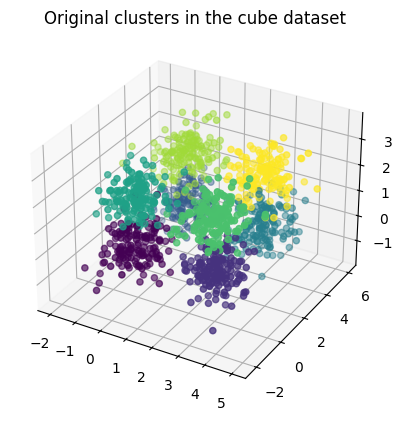

In [3]:

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(cube["x"], cube["y"], cube["z"], c=cube["c"])
plt.title("Original clusters in the cube dataset")


using 8 clusters I will train the network with default parameters to determine the network performance on different epochs. I will use the *Davies-Bouldin*, *homogenity* and *completness* and visuall assesement to do so.

In [4]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

In [5]:
M = 2
N = 4

max_epochs = 200
n_trials = 10


In [13]:
koh = KohonenNetwork(M, N, vec_dim=3, neighboring_func=GaussianNeighboringFunc(0.4))

koh.fit(cube[["x", "y", "z"]].values, 100, verbose=False, history=False)

In [14]:
def save_scores(scores, filename):
    with open(Path("scores") / ("cube_" + filename + ".pkl"), "wb") as f:
        pickle.dump(scores, f)

def load_scores(filename):
    with open(Path("scores") / ("cube_" + filename + ".pkl"), "rb") as f:
        return pickle.load(f)
    

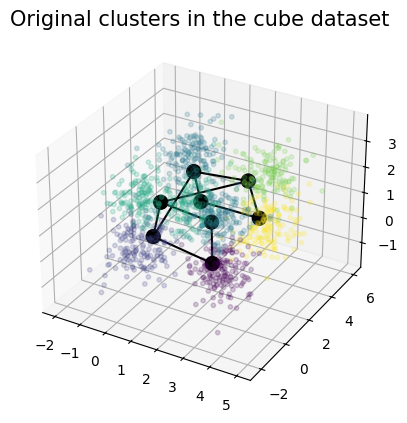

In [15]:

fig = plt.figure()

ax = plt.axes(projection='3d')

labels = koh.predict(cube[["x", "y", "z"]].values)

ax.scatter3D(cube["x"], cube["y"], cube["z"], c=labels, s=10, alpha = 0.2)
plt.title("Original clusters in the cube dataset", fontsize=15)

koh.plot_graph(show=False, ax=ax, s=100, alpha=1, color="black")

ax.grid(True)
ax.set_axis_on()
plt.style.use('default')

In [ ]:

scores = list(range(n_trials))
labels = hexagon["c"].values

for trail in range(n_trials):
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    koh = KohonenNetwork(M, N, GaussianNeighboringFunc(initial_neighbouring_radius=0.5), lambda_param=1, initial_learning_rate=1, vec_dim = 3)
    print(f"Trail {trail}")
    old_labels = koh.fit(cube[["x", "y", "z"]].values, max_epochs,  verbose = False, history=True)
    print(f"Finished training in trail {trail}")
    for epoch in range(1, max_epochs):
        som_labels = old_labels[epoch]

        scores[trail]["homogeneity"].append(homogeneity_score(cube["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(cube["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(cube["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(cube[["x", "y", "z"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(cube[["x", "y", "z"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(cube[["x", "y", "z"]].values, som_labels))


#save_scores(scores, "cube_epochs")

In [16]:
def save_scores(scores, filename):
    with open(Path("scores") / (filename + ".pkl"), "wb") as f:
        pickle.dump(scores, f)

def load_scores(filename):
    with open(Path("scores") / (filename + ".pkl"), "rb") as f:
        return pickle.load(f)
    

In [17]:
test_name = "cube_epochs_lambda_1"
#save_scores(scores, test_name)

In [18]:
scores = load_scores("epochs_lambda_1")

In [60]:
def create_summary_plots(scores, values, scores_start = 0, scores_end = -1, errorbar = True, errorevery=10, plot_title = "", suptitle="", save_path=None, baseline = True, n_trials = 10):
    if scores_end == -1:
        scores_end = scores_start + len(values) - 1
    
    mean_scores = {key: np.mean([scores[trail][key] for trail in range(n_trials)], axis=0) for key in scores[0].keys()}
    std_scores = {key: np.std([scores[trail][key] for trail in range(n_trials)], axis=0) for key in scores[0].keys()}

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    if errorbar:
        axs[0].errorbar(values[scores_start:scores_end], mean_scores["homogeneity"][scores_start:scores_end], yerr = std_scores["homogeneity"][scores_start:scores_end], label="SOM clustering", errorevery = errorevery); axs[0].set_title("Homogeneity")
        axs[1].errorbar(values[scores_start:scores_end], mean_scores["completeness"][scores_start:scores_end], yerr = std_scores["completeness"][scores_start:scores_end], label="SOM clustering", errorevery = errorevery); axs[1].set_title("Completeness")

        axs[2].errorbar(values[scores_start:scores_end], mean_scores["davies_bouldin"][scores_start:scores_end], yerr = std_scores["davies_bouldin"][scores_start:scores_end], label="SOM clustering", errorevery = errorevery); axs[2].set_title("Davies-Bouldin score")
    else:
        axs[0].plot(values[scores_start:scores_end], mean_scores["homogeneity"][scores_start:scores_end], label="SOM clustering"); axs[0].set_title("Homogeneity")
        axs[1].plot(values[scores_start:scores_end], mean_scores["completeness"][scores_start:scores_end], label="SOM clustering"); axs[1].set_title("Completeness")
        axs[2].plot(values[scores_start:scores_end], mean_scores["davies_bouldin"][scores_start:scores_end], label="SOM clustering"); axs[2].set_title("Davies-Bouldin score")
        
        axs[0].fill_between(values[scores_start:scores_end], mean_scores["homogeneity"][scores_start:scores_end] - std_scores["homogeneity"][scores_start:scores_end], mean_scores["homogeneity"][scores_start:scores_end] + std_scores["homogeneity"][scores_start:scores_end], alpha=0.2)
        axs[1].fill_between(values[scores_start:scores_end], mean_scores["completeness"][scores_start:scores_end] - std_scores["completeness"][scores_start:scores_end], mean_scores["completeness"][scores_start:scores_end] + std_scores["completeness"][scores_start:scores_end], alpha=0.2)
        axs[2].fill_between(values[scores_start:scores_end], mean_scores["davies_bouldin"][scores_start:scores_end] - std_scores["davies_bouldin"][scores_start:scores_end], mean_scores["davies_bouldin"][scores_start:scores_end] + std_scores["davies_bouldin"][scores_start:scores_end], alpha=0.2)
        
    if baseline:
        axs[2].axhline(davies_bouldin_score(cube[['x', 'y', "z"]].values, cube["c"].values), c="red", label="Original clustering")
        
        
    for j in range(3):
            
            axs[j].set_xlabel(plot_title)
            axs[j].set_ylabel("Score")
            axs[j].legend()


    plt.suptitle(suptitle)
    
    if save_path:
        plt.savefig(Path("plots") / ("cube_" + save_path + ".png"))  
    return fig, axs
    

In [20]:
scores = load_scores("cube_epochs_lambda_1")

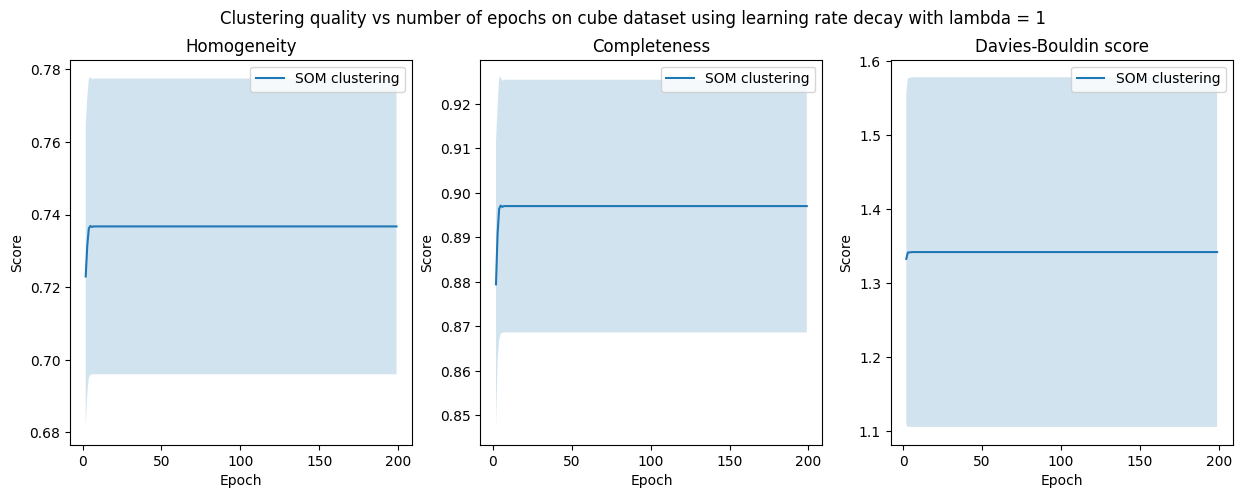

In [22]:
create_summary_plots(scores, list(range(1, max_epochs)), errorbar=False, scores_start = 1, baseline=False, plot_title="Epoch", suptitle="Clustering quality vs number of epochs on cube dataset using learning rate decay with lambda = 1", save_path="cube_epochs_lambda_1")

plt.show()

In [ ]:
M = 2
N = 3

max_epochs = 200
n_trials = 10

scores = list(range(n_trials))
labels = hexagon["c"].values

for trail in range(n_trials):
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    koh = KohonenNetwork(M, N, GaussianNeighboringFunc(initial_neighbouring_radius=0.5), lambda_param=5, initial_learning_rate=1)
    print(f"Trail {trail}")
    old_labels = koh.fit(hexagon[["x", "y"]].values, max_epochs, verbose = False, history=True)
    print(f"Finished training in trail {trail}")
    for epoch in range(1, max_epochs):
        som_labels = old_labels[epoch]

        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels))

save_scores(scores, "epochs_lambda_5")

In [23]:

scores = load_scores("epochs_lambda_5")

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Homogeneity'}, xlabel='Epoch', ylabel='Score'>,
        <Axes: title={'center': 'Completeness'}, xlabel='Epoch', ylabel='Score'>,
        <Axes: title={'center': 'Davies-Bouldin score'}, xlabel='Epoch', ylabel='Score'>],
       dtype=object))

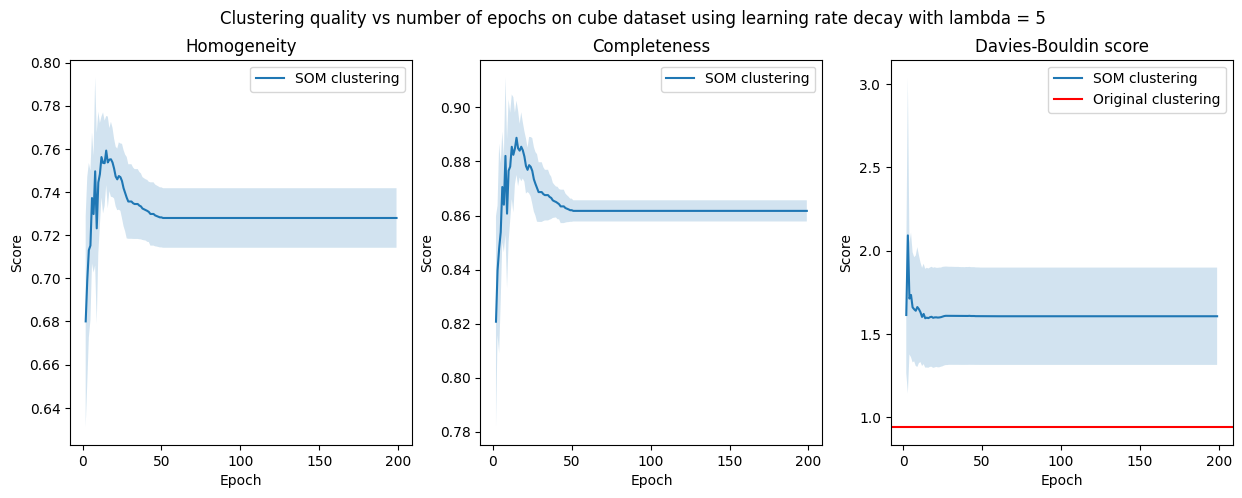

In [24]:
create_summary_plots(scores, list(range(1, max_epochs)), errorbar=False, scores_start = 1, baseline=True, plot_title="Epoch", suptitle="Clustering quality vs number of epochs on cube dataset using learning rate decay with lambda = 5", save_path="epochs_lambda_5")

In [111]:
M = 2
N = 3

max_epochs = 200
n_trials = 10

scores = list(range(n_trials))
labels = hexagon["c"].values

for trail in range(n_trials):
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    koh = KohonenNetwork(M, N, GaussianNeighboringFunc(initial_neighbouring_radius=0.5), lambda_param=10, initial_learning_rate=1)
    print(f"Trail {trail}")
    old_labels = koh.fit(hexagon[["x", "y"]].values, max_epochs, verbose = False, history=True)
    print(f"Finished training in trail {trail}")
    for epoch in range(1, max_epochs):
        som_labels = old_labels[epoch]

        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels))

save_scores(scores, "cube_epochs_lambda_10")

Trail 0
Finished training in trail 0
Trail 1
Finished training in trail 1
Trail 2
Finished training in trail 2
Trail 3
Finished training in trail 3
Trail 4
Finished training in trail 4
Trail 5
Finished training in trail 5
Trail 6
Finished training in trail 6
Trail 7
Finished training in trail 7
Trail 8
Finished training in trail 8
Trail 9
Finished training in trail 9


In [25]:
scores = load_scores("epochs_lambda_10")

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Homogeneity'}, xlabel='Epoch', ylabel='Score'>,
        <Axes: title={'center': 'Completeness'}, xlabel='Epoch', ylabel='Score'>,
        <Axes: title={'center': 'Davies-Bouldin score'}, xlabel='Epoch', ylabel='Score'>],
       dtype=object))

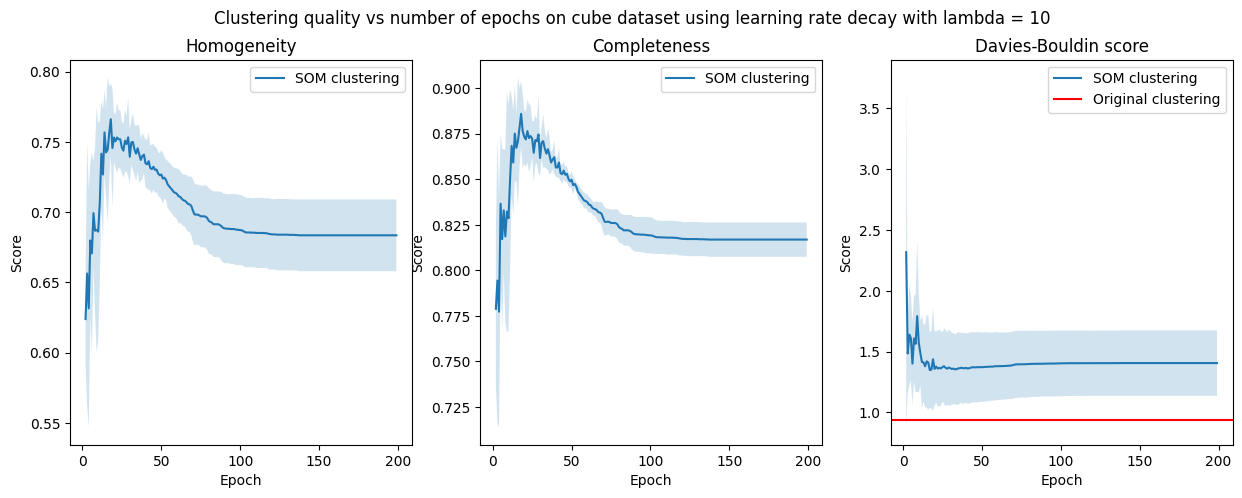

In [26]:
create_summary_plots(scores, list(range(1, max_epochs)), scores_start = 1, baseline=True, errorbar=False, plot_title="Epoch", suptitle="Clustering quality vs number of epochs on cube dataset using learning rate decay with lambda = 10", save_path="epochs_lambda_10")

# Cluster size

In [31]:
import math

def closestDivisors(n):
    a = round(math.sqrt(n))
    while n%a > 0: 
        a -= 1
    return a,n//a

In [32]:

cluster_sizes = [4, 6, 8, 10, 14, 20, 30, 40]
cluster_dims = [closestDivisors(size) for size in cluster_sizes]
cluster_dims

[(2, 2), (2, 3), (2, 4), (2, 5), (2, 7), (4, 5), (5, 6), (5, 8)]

In [ ]:
num_trails = 10
scores = list(range(num_trails))
labels = hexagon["c"].values

for trail in range(num_trails):
    print(f"Trail {trail}")
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    for dim in cluster_dims:
        size = dim[0] * dim[1]
        epochs = 10 * size
        koh = KohonenNetwork(dim[0], dim[1], GaussianNeighboringFunc(initial_neighbouring_radius=0.5), vec_dim=3, lambda_param=5)    
        koh.fit(cube[["x", "y", "z"]].values, epochs, history=False, verbose=False)
        som_labels = koh.predict(cube[["x", "y", "z"]].values, return_labels=True)
        scores[trail]["homogeneity"].append(homogeneity_score(cube["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(cube["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(cube["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(cube[["x", "y", "z"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(cube[["x", "y", "z"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(cube[["x", "y", "z"]].values, som_labels))

save_scores(scores, "cluster_sizes_05_lambda_5")

In [50]:
# save_scores(scores, "cluster_sizes")
scores = load_scores("cluster_sizes")

In [51]:
len(scores[0]["homogeneity"])

7

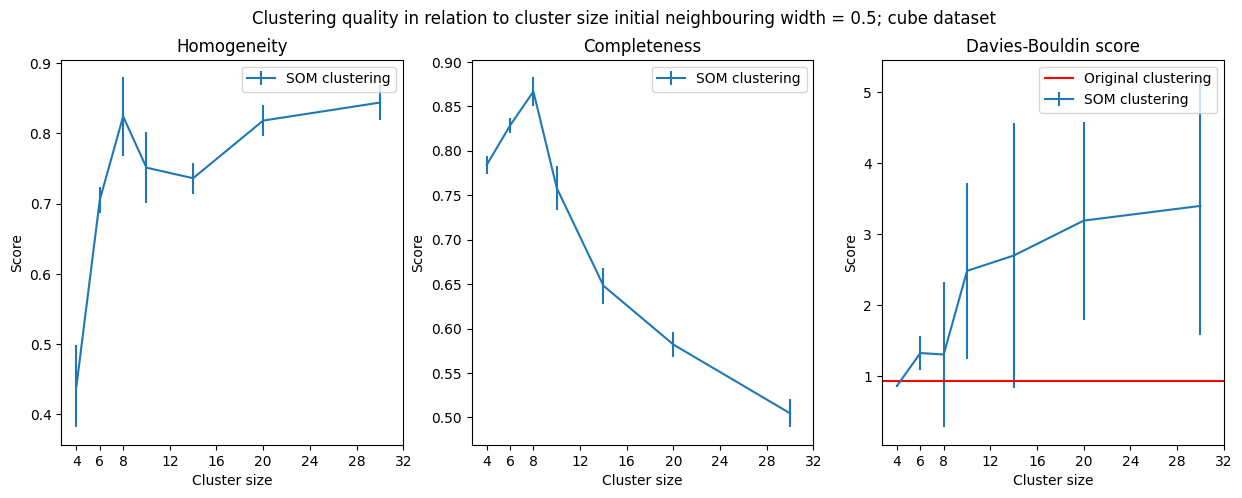

In [52]:
fig, axs = create_summary_plots(scores, cluster_sizes, scores_start = 0, scores_end = len(cluster_sizes) - 1, n_trials=10, errorevery=1, baseline=True, plot_title="Cluster size", suptitle="Clustering quality in relation to cluster size initial neighbouring width = 0.5; cube dataset", save_path="cluster_sizes_05")


for i in range(2):
    for j in range(3):
        
        #axs[i, j].axvline(6, c="green")
        axs[j].set_xticks([4, 6, 8, 12, 16, 20, 24, 28, 32])
plt.savefig(Path("plots") / "cube_cluster_sizes_05.png")

In [188]:
num_trails = 10
scores = list(range(num_trails))
labels = hexagon["c"].values

for trail in range(num_trails):
    print(f"Trail {trail}")
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    for dim in cluster_dims:
        size = dim[0] * dim[1]
        epochs = 10 * size
        koh = KohonenNetwork(dim[0], dim[1], GaussianNeighboringFunc(initial_neighbouring_radius=0.25), vec_dim=2)    
        koh.fit(hexagon[["x", "y"]].values, epochs, history=False, verbose=False)
        som_labels = koh.predict(hexagon[["x", "y"]].values, return_labels=True)
        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels))
        
save_scores(scores, "cluster_sizes_025")

Trail 0
Trail 1
Trail 2
Trail 3
Trail 4
Trail 5
Trail 6
Trail 7
Trail 8
Trail 9


In [53]:
scores = load_scores("cluster_sizes_025")

In [54]:
len(scores[0]["homogeneity"])

7

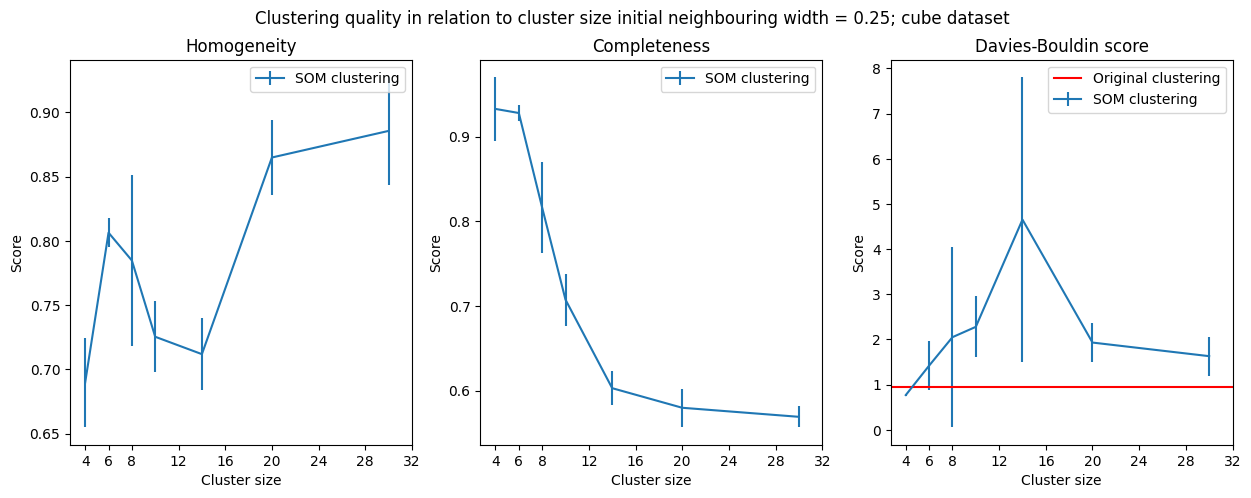

In [55]:
fig, axs = create_summary_plots(scores, cluster_sizes, scores_start = 0, scores_end = 7, n_trials=10, errorevery=1, baseline=True, plot_title="Cluster size", suptitle="Clustering quality in relation to cluster size initial neighbouring width = 0.25; cube dataset", save_path="cluster_sizes_025")

for i in range(2):
    for j in range(3):
        
        #axs[i, j].axvline(6, c="green")
        axs[j].set_xticks([4, 6, 8, 12, 16, 20, 24, 28, 32])
plt.savefig(Path("plots") / "cube_cluster_sizes_025.png")

# Szerokość sąsiedztwa

In [56]:
widths = np.linspace(0.1, 1, 10)

In [70]:
widths = np.linspace(0.1, 1, 10)

num_trails = 10

scores = list(range(num_trails))
epochs = 80

labels = cube["c"].values

for trail in range(num_trails):
    print(f"Trail {trail}")
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    for width in widths:
        koh = KohonenNetwork(2, 3, GaussianNeighboringFunc(initial_neighbouring_radius=width), vec_dim=3)    
        koh.fit(cube[["x", "y", "z"]].values, epochs, history=False, verbose=False)
        som_labels = koh.predict(cube[["x", "y", "z"]].values, return_labels=True)
        scores[trail]["homogeneity"].append(homogeneity_score(cube["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(cube["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(cube["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(cube[["x", "y", "z"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(cube[["x", "y", "z"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(cube[["x", "y", "z"]].values, som_labels))
        
save_scores(scores, "neighbouring_widths")

Trail 0


In [57]:
scores = load_scores("neighbouring_widths")

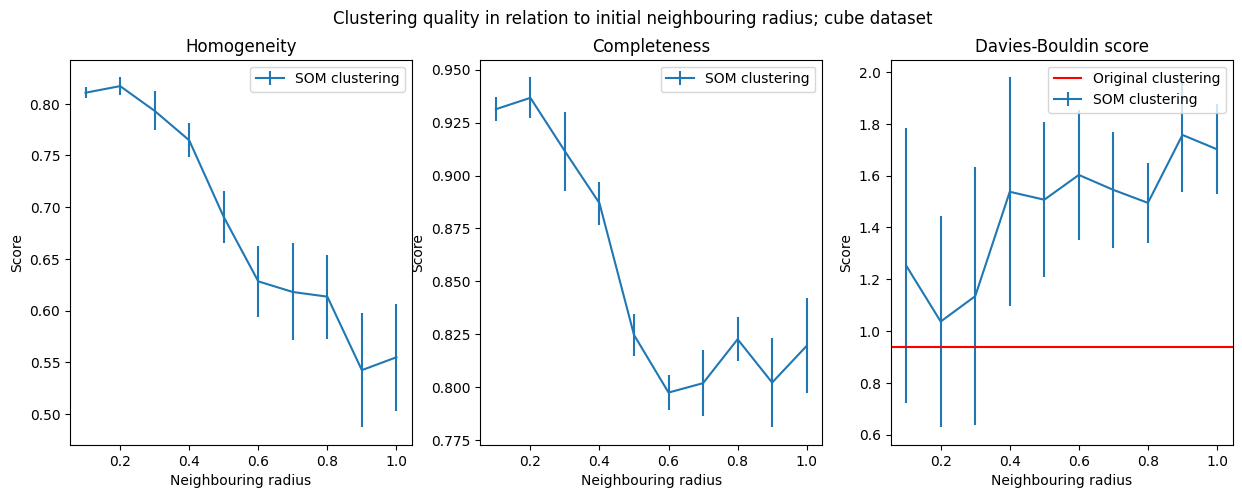

In [61]:
fig, axs = create_summary_plots(scores, widths, scores_start = 0, scores_end=len(widths), n_trials=10, errorevery=1, baseline=True, plot_title="Neighbouring radius", suptitle="Clustering quality in relation to initial neighbouring radius; cube dataset", save_path="neighbouring_radius")

plt.show()